## Assignment 8

**Dency Claris Thomas**

The goal of this lab is to examine and experiment with several techniques related to influence analysis
in complex networks. Influence is defined between two users and represents how
possible is for a user to adapt the behavior or copy the action of another user. 

We will first introduce the diffusion model which can be used to simulate a spreading process that takes place over the network.
 
Subsequently, we will utilize the structure of the network to identify influencers based in a heuristic manner.

Finally, we will examine the algorithmic solution to the problem of influence maximization,
which is choosing the optimum nodes to maximize the spread of information, and compare it with
the heuristic approach based on the simulations.

We will again rely on the network sciecne dataset for our use case. The following questions can be answered with the help of networkx and NDlib. You may also use other packages to deal with the problem. Please answer the following questions on the networks you have and submit your executable code.

In [1]:
path = "C:\\Users\\dency\\OneDrive\\Documents\\ACN\\Analysis-of-Complex-Networks---Assignments\\datasets\\"

In [2]:
# download a file from a url 
import requests

def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)

download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=path+"netscience.gml")

In [3]:
# Read the data and show the basic information
import networkx as nx

# Define the path to the dataset
file_path = "datasets/netscience.gml"

# Read the GML file into a NetworkX graph
coauthorship_network = nx.read_gml(file_path)

# Display basic information about the graph
print("Basic Information about the Coauthorship Network:")
print(f"Number of nodes: {coauthorship_network.number_of_nodes()}")
print(f"Number of edges: {coauthorship_network.number_of_edges()}")

# Check if the graph is directed
print(f"Is the graph directed? {'Yes' if coauthorship_network.is_directed() else 'No'}")

# Display additional properties
largest_cc = max(nx.connected_components(coauthorship_network), key=len)
print(f"Size of largest connected component: {len(largest_cc)}")


Basic Information about the Coauthorship Network:
Number of nodes: 1589
Number of edges: 2742
Is the graph directed? No
Size of largest connected component: 379


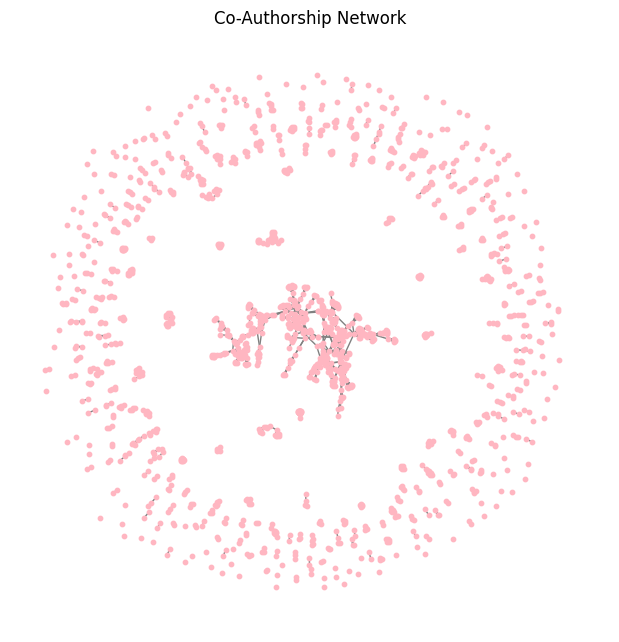

In [4]:
import matplotlib.pyplot as plt

# Plot the Network
plt.figure(figsize=(6,6))
nx.draw(coauthorship_network, with_labels=False, node_size=10, node_color="lightpink", edge_color="gray")
plt.title("Co-Authorship Network")
plt.show()

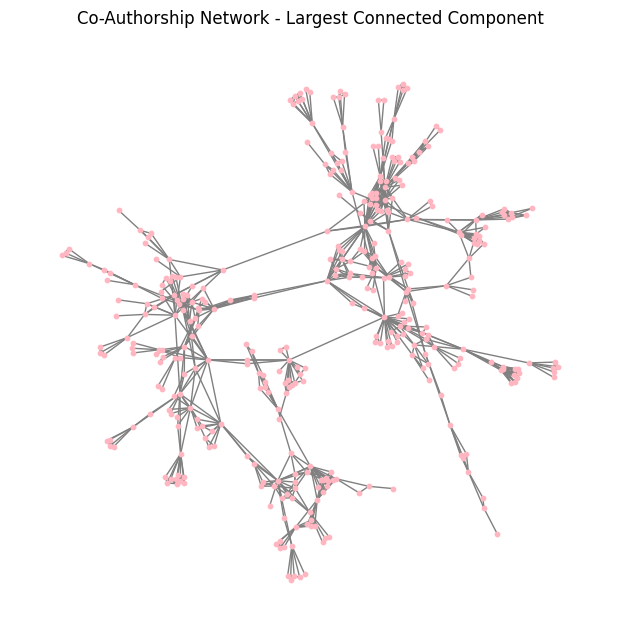

In [5]:
# Create the graph with the largest connected component
largest_cc_graph = coauthorship_network.subgraph(largest_cc).copy()

# Plot the graph
plt.figure(figsize=(6,6))
nx.draw(largest_cc_graph, with_labels=False, node_size=10, node_color="lightpink", edge_color="gray")
plt.title("Co-Authorship Network - Largest Connected Component")
plt.show()

**(a)** We will first create a method to evaluate our chosen seeds, based on epidemic simulation. As a means for evaluation, we use the Independent Cascade model, to compute the number of influenced nodes during an influence spread over the network. 
This model assumes that a node v has only one chance to influence each of its neighbors u based on the probability `p v,u` . 
We define the model's parameters (threshold=0.01) based on common approaches in the literature, and run the epidemic through 10 steps in order to get an approximation and retreive fast results (in normal circumstances it is 10 thousand).


In terms of implementation we will define a function $simulate\_spreading$ that performs the simulation using the IndependentCascadeModel and ModelConfig from NDlib.
More specficially, we have to loop through the edges and add a variable named "threshold" that resembles the probability of influencing a node's neighbors (set to $0.01$ as is common in the literature for dense graphs), using the function $add\_edge\_configuration$.


In [6]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import random

def simulate_spreading(G, seed_set, sim=10, num_steps=10, threshold=0.01):
    """
    Given the graph and the seed set, compute the number of infected nodes after the end of a spreading process using the Independent Cascade model.

    Args:
        G: NetworkX graph
        seed_set: List of seed nodes
        sim: Number of simulations to average over
        num_steps: Number of steps for the simulation
        threshold: Probability of influence for each edge (default = 0.01)
    
    Returns:
        float: Average number of influenced nodes across simulations
    """
    # Initialize the Independent Cascade Model
    model = ep.IndependentCascadesModel(G)

    # Configure the model
    config = mc.Configuration()
    
    # Add seeds as initial infected nodes
    config.add_model_initial_configuration("Infected", seed_set)

    # Loop through all edges and set the threshold
    for edge in G.edges():
        config.add_edge_configuration("threshold", edge, threshold)
    
    # Apply the configuration to the model
    model.set_initial_status(config)
    
    total_influenced = 0

    # Run the simulations
    for _ in range(sim):
        iterations = model.iteration_bunch(num_steps)
        last_iteration = iterations[-1]  # Get the final state
        influenced_count = len(last_iteration['status'].keys())  # Count influenced nodes
        total_influenced += influenced_count

    # Return the average number of influenced nodes
    return total_influenced / sim

# Define parameters
seed_set = random.sample(list(largest_cc), 5)  # Randomly select 5 seed nodes
simulations = 10
steps = 10
threshold_value = 0.5

# Run the simulation on the largest connected component
average_influenced = simulate_spreading(largest_cc_graph, seed_set, sim=simulations, num_steps=steps, threshold=threshold_value)

print(f"Average number of influenced nodes: {average_influenced}")


Average number of influenced nodes: 1.3


**(b)** Compute K-core score:  Given our undirected network G, C k is defined as the k-core subgraph of G if it is a maximal connected subgraph in which all nodes have degree at least k. Then, each node v ∈ V has a core number c(v) = k, if it belongs to a k-core but not to a (k + 1)-core. The cohesion of subgraphs increases as k increases. Let us denote as C the set of nodes with the maximum core number k\_max. Compute the top 20 nodes in terms of the k-core they belong to and simulate their spreading.

In [7]:
import networkx as nx

# Compute the core numbers for all nodes
core_numbers = nx.core_number(largest_cc_graph)

# Sort nodes by their core number in descending order
sorted_nodes_by_core = sorted(core_numbers.items(), key=lambda item: item[1], reverse=True)

# Extract the top 20 nodes based on their core numbers
top_20_nodes = [node for node, core in sorted_nodes_by_core[:20]]

# Print the top 20 nodes and their core numbers
print("Top 20 Nodes by Core Number:")
for node, core in sorted_nodes_by_core[:20]:
    print(f"Node: {node}, Core Number: {core}")

# Simulate spreading using the top 20 nodes as seed set
# Use the same parameters from the previous question
average_influenced_top_20 = simulate_spreading(
    G=largest_cc_graph,
    seed_set=top_20_nodes,
    sim=10,
    num_steps=10,
    threshold=0.5
)

# Print the result of the simulation
print(f"\nAverage number of influenced nodes (Top 20 Core Nodes as Seeds): {average_influenced_top_20}")


Top 20 Nodes by Core Number:
Node: FARKAS, I, Core Number: 8
Node: NEDA, Z, Core Number: 8
Node: JEONG, H, Core Number: 8
Node: DERENYI, I, Core Number: 8
Node: SCHUBERT, A, Core Number: 8
Node: BARABASI, A, Core Number: 8
Node: RAVASZ, E, Core Number: 8
Node: VICSEK, T, Core Number: 8
Node: OLTVAI, Z, Core Number: 8
Node: BRODER, A, Core Number: 7
Node: KURTHS, J, Core Number: 7
Node: SCHNITZLER, A, Core Number: 7
Node: RAJAGOPALAN, S, Core Number: 7
Node: WEULE, M, Core Number: 7
Node: TOMKINS, A, Core Number: 7
Node: WIENER, J, Core Number: 7
Node: RAGHAVAN, P, Core Number: 7
Node: KUMAR, R, Core Number: 7
Node: TASS, P, Core Number: 7
Node: STATA, R, Core Number: 7

Average number of influenced nodes (Top 20 Core Nodes as Seeds): 0.8


**(c)** Implement Greedy IM: Influence Maximization is the problem that lies in the heart of influence analysis and addresses how to find a set of nodes, such that if they start a diffusion, the number of infected nodes in the network (influenced spread) will be maximized. It has a broad range of applications, from viral marketing, which was the initial motivation for the problem, to epidemiological containment and political campaign management.
The problem can be formulated as follows: given a social network, a diffusion model with some parameters and a number k, find a seed set S $\subset$ V of size k such that the influence spread is maximized.  We will use the well known method from Kempe et al.[ [1](https://dl.acm.org/doi/pdf/10.1145/956750.956769?casa_token=tkl-2BIJoXIAAAAA:SD8O7LcvEPGyGAdv8cHEwSqgn3Jz0UeHvpRK3-xYB2Z9C7gy-iOQpeHoFqOWzDMfAskBgVzYrpzS)] that is based on the fact that the function of the influence spread under the IC and LT models is monotone non-decreasing and submodular, which gives a  $(1-1/e)$ approximation ratio to the optimal.

To simplify and speed up the implementation to less then a minute, we are going to use only one simple simulation based on the function defined above. Moreover, we will reduce the search space of the algorithm by giving as an input a set of selected nodes to search on. To find a shorter set of such nodes, you can use the filter\_graph function below, that removes nodes under a certain degree, and set an appropriate threshold e.g. 3. We utilize these shortcuts because we need to make the algorithm run in time for the lab. You are encouraged to experiment further in your own time with an implementation that matches more the original algorithm, mainly in order to get a firm understanding of the computational demand of influence maximization.

In [8]:
def filter_graph(G,threshold):
    G_ = G.copy()
    to_remove = [i for i in G_.nodes() if G_.degree(i) < threshold]
    G_.remove_nodes_from(to_remove)
    print("Removed "+str(len(to_remove))+" of "+str(len(G.nodes()))+" nodes")
   
    return G_

In [9]:
# Define the greedy influence maximization algorithm
def greedy_algorithm(G, selected_nodes, size, sim=10, num_steps=10, threshold=0.01):
    """
    Greedy influence maximization algorithm for a subset of nodes (Kempe et al., 2003).

    Args:
        G: Filtered NetworkX graph
        selected_nodes: Candidate nodes to consider for seed set
        size: Desired size of the seed set
        sim: Number of simulations for influence spread
        num_steps: Number of steps in each simulation
        threshold: Probability of influence for each edge
    
    Returns:
        list: Seed set of nodes that maximize influence spread
    """
    seed_set = []

    for _ in range(size):
        best_node = None
        best_spread = -1

        for node in selected_nodes:
            if node not in seed_set:
                # Evaluate influence spread with the current node added to the seed set
                current_seed_set = seed_set + [node]
                spread = simulate_spreading(G, current_seed_set, sim=sim, num_steps=num_steps, threshold=threshold)

                # Track the node with the maximum spread
                if spread > best_spread:
                    best_spread = spread
                    best_node = node
        
        # Add the best node to the seed set
        seed_set.append(best_node)
        print(f"Selected Node: {best_node}, Spread: {best_spread}")

    return seed_set

# Apply the filter and run the greedy algorithm
# Filter the graph to retain nodes with degree >= 3
filtered_graph = filter_graph(largest_cc_graph, threshold=3)

# Define the candidate nodes (those retained after filtering)
candidate_nodes = list(filtered_graph.nodes())

# Run the greedy algorithm to find the top 5 influential nodes
seed_set_size = 5
top_seeds = greedy_algorithm(filtered_graph, candidate_nodes, size=seed_set_size, sim=10, num_steps=10, threshold=0.3)

print(f"\nTop {seed_set_size} influential nodes: {top_seeds}")


Removed 101 of 379 nodes
Selected Node: CHUNG, J, Spread: 3.4
Selected Node: FRASCA, M, Spread: 4.0
Selected Node: STAGNI, C, Spread: 4.0
Selected Node: PARK, E, Spread: 3.3
Selected Node: VALVERDE, S, Spread: 3.6

Top 5 influential nodes: ['CHUNG, J', 'FRASCA, M', 'STAGNI, C', 'PARK, E', 'VALVERDE, S']


**(d)** Plot the spreading of k-core and greedy IM for a seed set of 20 to compare them.

Selected Node: BARRAT, A, Spread: 3.8
Selected Node: MAGHOUL, F, Spread: 4.7
Selected Node: SOUSA, A, Spread: 4.1
Selected Node: MARCHIORI, M, Spread: 4.1
Selected Node: ADLER, J, Spread: 4.5
Selected Node: GHIM, C, Spread: 5.0
Selected Node: FLAMMINI, A, Spread: 3.2
Selected Node: WATTS, D, Spread: 3.5
Selected Node: HAVLIN, S, Spread: 3.8
Selected Node: PARISI, D, Spread: 3.7
Selected Node: WARMBRAND, C, Spread: 2.9
Selected Node: ARENAS, A, Spread: 2.8
Selected Node: RIGON, R, Spread: 3.2
Selected Node: FEDROFF, N, Spread: 2.8
Selected Node: FLAKE, G, Spread: 2.8
Selected Node: LOUNASMAA, O, Spread: 3.1
Selected Node: HOLTER, N, Spread: 2.3
Selected Node: REDNER, S, Spread: 3.3
Selected Node: HOLYST, J, Spread: 2.4
Selected Node: DIGARBO, A, Spread: 3.3


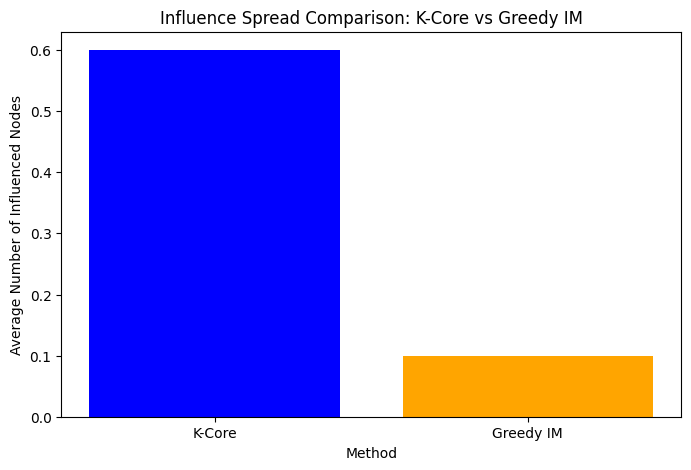

K-Core Spread: 0.6
Greedy IM Spread: 0.1


In [11]:
import matplotlib.pyplot as plt

# Extract the top 20 nodes based on k-core values
top_kcore_nodes = [node for node, _ in sorted(core_numbers.items(), key=lambda x: x[1], reverse=True)[:20]]

# Use the Greedy IM algorithm to get the top 20 nodes
top_greedy_nodes = greedy_algorithm(filtered_graph, candidate_nodes, size=20, sim=10, num_steps=10, threshold=0.3)

# Compare the influence spread for both seed sets
kcore_spread = simulate_spreading(filtered_graph, top_kcore_nodes, sim=10, num_steps=10, threshold=0.3)
greedy_spread = simulate_spreading(filtered_graph, top_greedy_nodes, sim=10, num_steps=10, threshold=0.3)

# Plot the results
methods = ["K-Core", "Greedy IM"]
spreads = [kcore_spread, greedy_spread]

plt.figure(figsize=(8, 5))
plt.bar(methods, spreads, color=["blue", "orange"])
plt.title("Influence Spread Comparison: K-Core vs Greedy IM")
plt.ylabel("Average Number of Influenced Nodes")
plt.xlabel("Method")
plt.show()

print(f"K-Core Spread: {kcore_spread}")
print(f"Greedy IM Spread: {greedy_spread}")
